In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

## Collaborators: Robin Dhillon, Samson Bakos, Markus Nam, Manvir Singh


# METRIC: RECALL
# FINAL SCORE: 65.8%

<div class="alert alert-info">

## 1. The Prediction Problem <a name="2"></a> 

In this mini project, we have a classification problem of predicting whether a credit card client will default or not. We use the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset), which contains 30,000 examples and 24 features. The goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled as "default.payment.next.month" in the data.  We rename this column to simply call it `default`. The values under this column are 0 for no default and 1 for default. The characteristics available to us to predict whether a person will default or not include their age, gender, education and payment history over the past few months. Based on intuition, the person's payment history should be extremely crucial in making predictions but we will assess if this is true by building different machine learning models and checking the importances of the features

In [2]:
# Imports
import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv').rename(columns = {"default.payment.next.month":"default"})
cc_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Upon looking at the dataset in Excel, we noticed there are some individuals with no bill amount at all i.e all BILL_AMT are 0 but still the individuals are being classified as defaulters. We decided to drop these rows.

In [4]:
cc_df = cc_df[cc_df.loc[:,'BILL_AMT1':'BILL_AMT6'].sum(axis=1)!=0]
cc_df.shape

(29130, 25)

<div class="alert alert-info">

## 2. Data splitting <a name="2"></a>

##### Further splitting into X_train, y_train, X_test and y_test is done below. We chose a test size of 20%. 

In [5]:
train_df, test_df = train_test_split(cc_df, test_size=0.20, random_state=123)

In [6]:
train_df.shape

(23304, 25)

In [7]:
test_df.shape

(5826, 25)

<div class="alert alert-info">

## 3. EDA <a name="3"></a>

Below, we perform exploratory data analysis on the train set and summarize some of the initial observations. Additionally, we pick an appropriate metric for assessment of our model(s).

- Our positive class is 1 under the "default" column.
- We have class imbalance since approximately 22% of the examples are defaulting while 78% are not defaulting. 
- We see that "EDUCATION" has 7 unique categories to it whereas the data dictionary says there should be 6 categories. Categories 5 and 6 both mean "Unknown" and there is an extra category 0. Since there are only 345 observations under Category 0, 5 or 6 in total,  we decided to group all the 3 categories into Category 4  ("others"). 
- Similarly we see an extra category 0 with 54 observations in MARRIAGE which we have included under Category 3 ("others").
- We also noticed that there are some observations in all the "PAY_" columns with values of -2 and 0 which are not defined in the data dictionary. There is speculation as to the meaning of these values, such as indicating no usage of card (-2). While not confirmed, the speculated values match the natural ordinality of the values, so we will keep them.
- The "BILL_AMT_" columns also have negative values which could mean reversals or the individual paid more than the bill amount before the bill was generated.
- There seems to be a high correlation between consecutive PAY_ columns like PAY_2 and PAY_3 etc as well as between consecutive BILL_AMT_ columns. If a person doesn't pay one month they seem likely to do so again.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23304 entries, 23114 to 20565
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         23304 non-null  int64  
 1   LIMIT_BAL  23304 non-null  float64
 2   SEX        23304 non-null  int64  
 3   EDUCATION  23304 non-null  int64  
 4   MARRIAGE   23304 non-null  int64  
 5   AGE        23304 non-null  int64  
 6   PAY_0      23304 non-null  int64  
 7   PAY_2      23304 non-null  int64  
 8   PAY_3      23304 non-null  int64  
 9   PAY_4      23304 non-null  int64  
 10  PAY_5      23304 non-null  int64  
 11  PAY_6      23304 non-null  int64  
 12  BILL_AMT1  23304 non-null  float64
 13  BILL_AMT2  23304 non-null  float64
 14  BILL_AMT3  23304 non-null  float64
 15  BILL_AMT4  23304 non-null  float64
 16  BILL_AMT5  23304 non-null  float64
 17  BILL_AMT6  23304 non-null  float64
 18  PAY_AMT1   23304 non-null  float64
 19  PAY_AMT2   23304 non-null  float64
 20  PA

In [9]:
train_df.nunique()

ID           23304
LIMIT_BAL       80
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    18706
BILL_AMT2    18421
BILL_AMT3    18124
BILL_AMT4    17776
BILL_AMT5    17333
BILL_AMT6    17028
PAY_AMT1      6885
PAY_AMT2      6843
PAY_AMT3      6505
PAY_AMT4      6025
PAY_AMT5      5966
PAY_AMT6      5987
default          2
dtype: int64

In [10]:
prop_neg = round(train_df['default'].value_counts()[0]/train_df.shape[0],2)
prop_pos = round(train_df['default'].value_counts()[1]/train_df.shape[0],2)

print (f"Proportion of positive class:{prop_pos}")
print (f"Proportion of negative class:{prop_neg}")

Proportion of positive class:0.22
Proportion of negative class:0.78


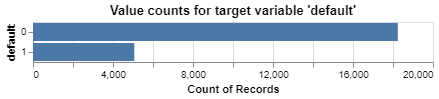

In [11]:
alt.Chart(train_df,title = "Value counts for target variable 'default'").mark_bar().encode(
    y = alt.Y("default:N"),
    x = alt.X("count()"))

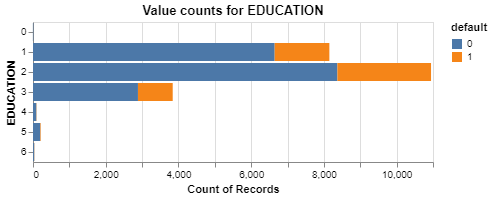

In [12]:
alt.Chart(train_df,title = "Value counts for EDUCATION").mark_bar().encode(
    y = alt.Y("EDUCATION:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

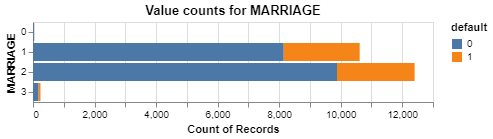

In [13]:
alt.Chart(train_df,title = "Value counts for MARRIAGE").mark_bar().encode(
    y = alt.Y("MARRIAGE:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

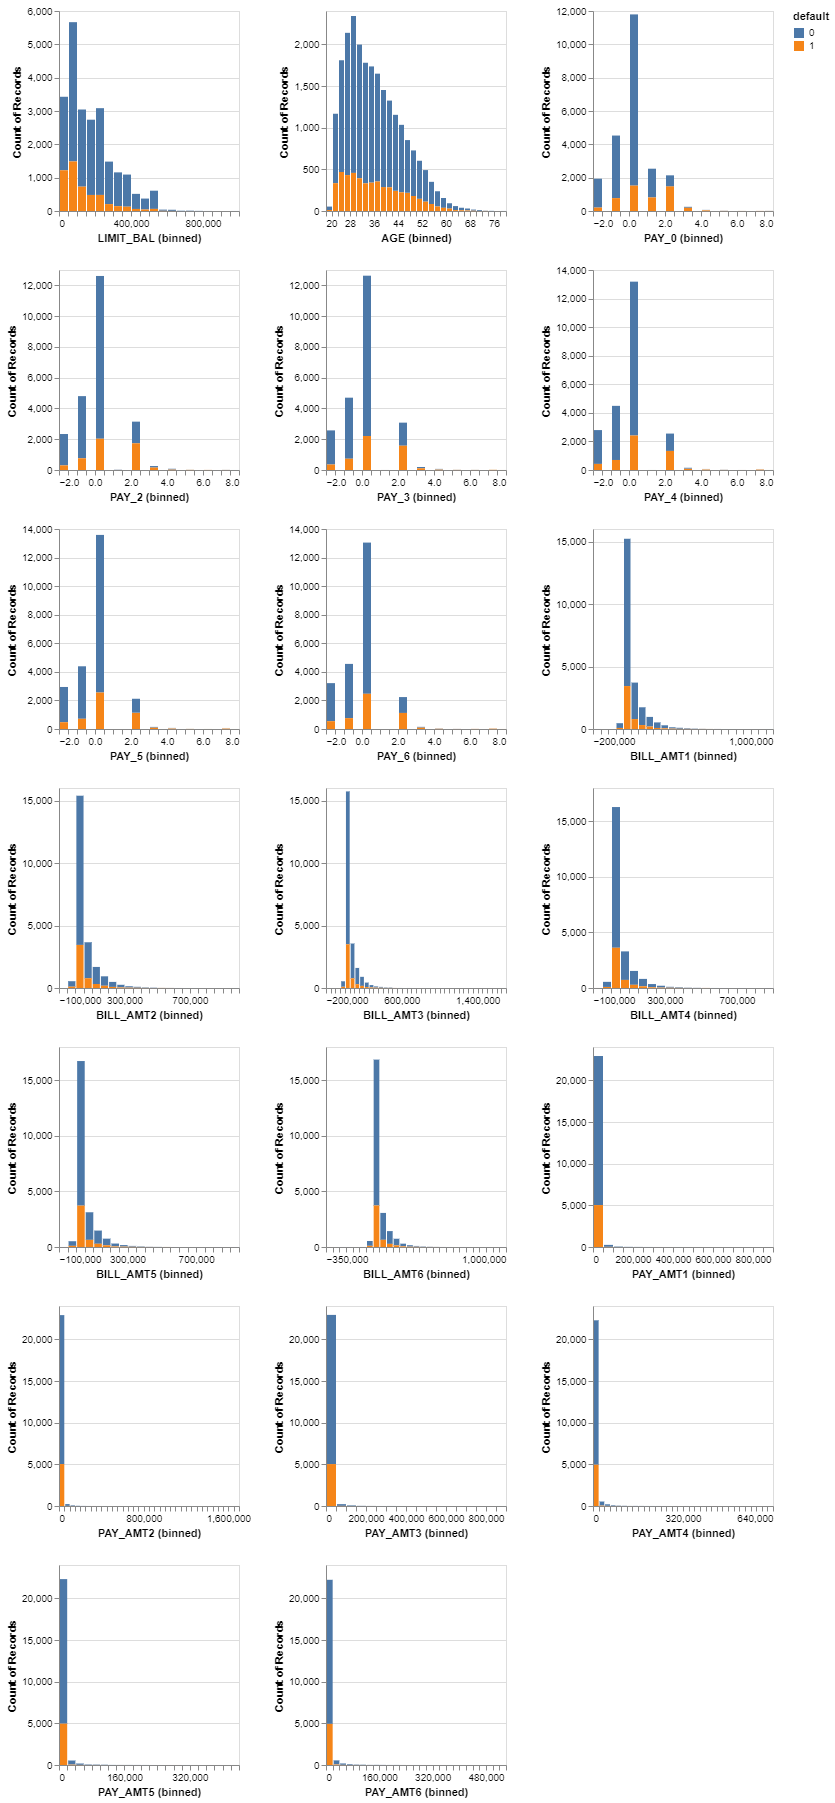

In [14]:
numeric_cols = train_df.select_dtypes(
    include=np.number).drop(
    columns=["ID", "SEX", "default", "MARRIAGE", "EDUCATION"]).columns.to_list()

alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    color='default:N'
).properties(
    width=180,
    height=200
).repeat(
    numeric_cols, columns=3
)

In [15]:
train_df[numeric_cols].corr('kendall').style.background_gradient()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.131779,-0.237038,-0.268373,-0.258503,-0.240751,-0.219675,-0.205549,0.092536,0.087368,0.092922,0.096039,0.098858,0.102886,0.228964,0.231723,0.236109,0.233656,0.241166,0.256385
AGE,0.131779,1.000000,-0.050595,-0.060349,-0.060294,-0.058086,-0.059998,-0.056172,0.011452,0.012238,0.012562,0.008041,0.009296,0.008717,0.033434,0.041956,0.032843,0.036711,0.034340,0.035305
PAY_0,-0.237038,-0.050595,1.000000,0.651403,0.547391,0.515548,0.485602,0.456179,0.266036,0.268999,0.258192,0.251179,0.243244,0.235635,-0.077176,-0.045156,-0.041377,-0.026940,-0.020122,-0.034307
PAY_2,-0.268373,-0.060349,0.651403,1.000000,0.744246,0.643324,0.600948,0.556894,0.401564,0.388627,0.362467,0.345491,0.330518,0.317540,-0.044585,0.008570,0.010722,0.019331,0.023161,0.014554
PAY_3,-0.258503,-0.060294,0.547391,0.744246,1.000000,0.746045,0.647590,0.595340,0.361118,0.418469,0.397471,0.375386,0.356580,0.340381,0.121662,-0.032065,0.022285,0.040792,0.044929,0.029804
PAY_4,-0.240751,-0.058086,0.515548,0.643324,0.746045,1.000000,0.771896,0.662369,0.352158,0.393205,0.450043,0.432896,0.404379,0.383764,0.093141,0.148982,-0.009804,0.059728,0.076699,0.067910
PAY_5,-0.219675,-0.059998,0.485602,0.600948,0.647590,0.771896,1.000000,0.770312,0.346392,0.381283,0.426259,0.485475,0.462619,0.428011,0.085656,0.128916,0.160215,0.029647,0.097097,0.093750
PAY_6,-0.205549,-0.056172,0.456179,0.556894,0.595340,0.662369,0.770312,1.000000,0.334737,0.366422,0.400358,0.443267,0.501123,0.471536,0.085051,0.105313,0.139497,0.181310,0.054586,0.110936
BILL_AMT1,0.092536,0.011452,0.266036,0.401564,0.361118,0.352158,0.346392,0.334737,1.000000,0.806192,0.725998,0.656554,0.609968,0.571007,0.367968,0.337232,0.304537,0.305664,0.290182,0.282848
BILL_AMT2,0.087368,0.012238,0.268999,0.388627,0.418469,0.393205,0.381283,0.366422,0.806192,1.000000,0.799521,0.712527,0.652694,0.608829,0.486725,0.364077,0.331197,0.324764,0.313073,0.302004


In [16]:
# recategorizing classses 0, 5, 6 in education as "Others" for train
train_df['EDUCATION'] = train_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for train
train_df['MARRIAGE'] = train_df['MARRIAGE'].replace(0, 3)

# recategorizing classses 0, 5, 6 in education as "Others" for test
test_df['EDUCATION'] = test_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for test                
test_df['MARRIAGE'] = test_df['MARRIAGE'].replace(0, 3)

<div class="alert alert-info">

## 4. Feature engineering

We now carry out feature engineering; new features that are potentially relevant for the problem are created. Specifically, four new features have been created:
- Max of the pay statuses:
   - This feature reflects the longest the individual has gone without paying a bill throughout their credit payment history as depicted in the dataset. A larger value would indicate an individual did not pay the bill for a long time. 'max' was chosen as it indicates the most severe continuous failure to pay. Summing this value was also tested (total payment behavior) but this was found to be a less powerful feature
- Sum of BILL_AMT_
   - This shows the total amount due for an individual.
- Sum of PAY_AMT_
   - This shows the total amount paid by an individual.
- Average of payment ratio
   - We first calculate the payment ratio per month (e.g. PAY_AMT1/BILL_AMT2 due to time lag), and then take the average. This shows the individual's repayment ability.
   - To deal with division by zero (i.e. BILL_AMT_ is zero), we set the payment ratio of the month to 1.

In [17]:
# creating total_pay for train
train_df = train_df.assign(longest_unpaid_streak=train_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for train
train_df = train_df.assign(total_bill=train_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for train
train_df = train_df.assign(total_paid=train_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for train (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(train_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(train_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
train_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# creating total_pay for test
test_df = test_df.assign(longest_unpaid_streak=test_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for test
test_df = test_df.assign(total_bill=test_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for test
test_df = test_df.assign(total_paid=test_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for test (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(test_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(test_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
test_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

In [18]:
# creating X_train, y_train, X_test and y_test
X_train = train_df.drop(columns='default')
y_train = train_df['default']
X_test = test_df.drop(columns='default')
y_test = test_df['default']

<div class="alert alert-info">

## 5. Preprocessing and transformations <a name="5"></a>

Here, we identify different feature types and the transformations we need to apply on each feature type. A column transformer is used to account for the different transformations.

- We drop ID which is an identifier column and SEX due to ethical concerns.
- We treat EDUCATION as an ordinal feature and MARRIAGE as a categorical feature.

In [19]:
drop_features = ['ID', 'SEX']
numeric_features = ['LIMIT_BAL', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'longest_unpaid_streak', 'total_bill', 'total_paid', 'avg_pay_ratio']
ordinal_features = ['EDUCATION']
categorical_features = ['MARRIAGE']

ordinal_levels = [1, 2, 3, 4]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(categories=[ordinal_levels]), ordinal_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
    ("drop", drop_features)   
)

<div class="alert alert-info">

## 6. Baseline model <a name="6"></a>

As a first step, a baseline model is trained using a `DummyClassifier` and its performance is reported.

In [20]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier()
cross_val_results = {}
cross_val_results['dummy'] = (pd.DataFrame(cross_validate(dc,
                                                         X_train,
                                                         y_train,
                                                         return_train_score=True,
                                                         scoring=classification_metrics))
                              .agg(['mean', 'std']).round(3).T)

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.004,0.002
score_time,0.007,0.004
test_accuracy,0.783,0.000
train_accuracy,0.783,0.000
test_precision,0.000,0.000
train_precision,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000


<div class="alert alert-info">

## 7. Linear models <a name="7"></a>

Loan default is a concern to many banks as this would affect the health of the institution and cause monetary loss. In view of this, catching genuine defaults is our main purpose, we will consider recall as our main metric of choice.

We now use `LogisticRegression` model along with hyperparameter optimization. Specifically, we tune the `class_weight` and `C` hyperparameters via `RandomizeSearchCV`. This gives us a validation recall score of 65.4%. It is very close to the training recall (65.3%) which means our model is not overfitting. Furthermore, our logistic regression model automatically deals with the class imbalance by choosing class_weight='balanced' during hyperparameter optimization. However we will try to get better scores by using other models.

In [21]:
from scipy.stats import lognorm, loguniform, randint

pipe_logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123,
                                                        max_iter=1000))

param_dist_logreg = {
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring = 'recall'
)
random_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                                                               ['ID',
                                                                                'SEX'])])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025315BF1FF0>,
                                        'logisticregression__class_weight': [None,
                                                                             'balanced']},
                   random_state=123, return_train_score=True, scoring='recall')

In [22]:
cross_val_results['logreg'] = pd.DataFrame(cross_validate(random_search_logreg.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg']

,mean,std
fit_time,0.115,0.041
score_time,0.016,0.002
test_accuracy,0.737,0.005
train_accuracy,0.739,0.002
test_precision,0.431,0.006
train_precision,0.433,0.003
test_recall,0.654,0.015
train_recall,0.653,0.002
test_f1,0.519,0.004
train_f1,0.521,0.003


In [23]:
random_search_logreg.best_params_

{'logisticregression__C': 2.0318358298265977,
 'logisticregression__class_weight': 'balanced'}

<div class="alert alert-info">

## 8. Different models <a name="8"></a>

below, we use three non-linear models and compare them to `LogisticRegression`
   - Naive Bayes
   - RandomForestClassifier
   - LGBM

Based on the results, Naive Bayes is outstanding in terms of recall score. The validation score for Naive Bayes is 86.5%, followed by logistic regression (65.4%) and LGBM (61%). In addition, Naive Bayes does not overfit at all because of the comparable test score and validation score. On the other hand, overfitting is observed in Random Forest and LGBM. We will further improve our models using feature selection and hyperparameter optimization.

# (Gaussian) Naive Bayes

In [24]:
NB_bal = make_pipeline(preprocessor, GaussianNB())

cross_val_results['NB_bal'] = pd.DataFrame(cross_validate(NB_bal,
                                  X_train,
                                  y_train,
                                  return_train_score=True,
                                  scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_bal']

,mean,std
fit_time,0.035,0.012
score_time,0.015,0.003
test_accuracy,0.434,0.032
train_accuracy,0.434,0.032
test_precision,0.260,0.009
train_precision,0.260,0.008
test_recall,0.865,0.022
train_recall,0.866,0.029
test_f1,0.399,0.008
train_f1,0.399,0.006


# Random Forest

In [25]:
RF_bal = make_pipeline(preprocessor,
                       RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal'] = pd.DataFrame(cross_validate(RF_bal,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_bal'] 

,mean,std
fit_time,4.587,0.165
score_time,0.097,0.002
test_accuracy,0.820,0.003
train_accuracy,1.000,0.000
test_precision,0.670,0.018
train_precision,1.000,0.000
test_recall,0.338,0.012
train_recall,1.000,0.000
test_f1,0.449,0.011
train_f1,1.000,0.000


# Light GBM

In [26]:
from lightgbm.sklearn import LGBMClassifier

LGBM_bal = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_bal'] = pd.DataFrame(cross_validate(LGBM_bal,
                                                            X_train,
                                                            y_train,
                                                            return_train_score=True,
                                                            scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['LGBM_bal']

,mean,std
fit_time,0.354,0.051
score_time,0.044,0.002
test_accuracy,0.768,0.006
train_accuracy,0.830,0.003
test_precision,0.474,0.009
train_precision,0.582,0.007
test_recall,0.610,0.018
train_recall,0.778,0.009
test_f1,0.533,0.005
train_f1,0.666,0.005


In [27]:
combined_results = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

combined_results

,dummy,logreg,NB_bal,RF_bal,LGBM_bal
fit_time,0.004,0.115,0.035,4.587,0.354
score_time,0.007,0.016,0.015,0.097,0.044
test_accuracy,0.783,0.737,0.434,0.820,0.768
train_accuracy,0.783,0.739,0.434,1.000,0.830
test_precision,0.000,0.431,0.260,0.670,0.474
train_precision,0.000,0.433,0.260,1.000,0.582
test_recall,0.000,0.654,0.865,0.338,0.610
train_recall,0.000,0.653,0.866,1.000,0.778
test_f1,0.000,0.519,0.399,0.449,0.533
train_f1,0.000,0.521,0.399,1.000,0.666


<div class="alert alert-info">

## 9. Feature selection

We'll employ Feature Selection to select the relevant features (and hence shrink/remove the irrelevant features). We use `RFECV` to reduce the feature space, using `RidgeClassifier` to generate feature importance. We start with 28 features and using `RidgeClassifier` to reduce the feature space leaves us with the 5 most important features.

Key findings: 
* Using feature selection leads to
    * better validation score for random forest;
        * Reducing the number of features does slightly reduce overfitting, we will keep the feature selection in the pipeline for random forest.
    * marginally worse validation score for logistic regression and LGBM;
        * The reduction in the scores is extremely small. By removing 23 features, we are significantly reducing the complexity of our model. So for both models we will keep the RFECV step, using only the subset of 5 features in our model.
    * significantly worse validation score for Naive Bayes;
        * Since no improvement is observed, we will abandon the feature selection in the pipeline for Naive Bayes

# Logistic Regression

In [28]:
#Baseline feature counts

pipe_logreg.fit(X_train, y_train) 
pipe_logreg.named_steps["logisticregression"].n_features_in_

28

In [29]:
# Linear Classifier

from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifier

logreg_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           LogisticRegression(class_weight="balanced",
                                              random_state=123,
                                              max_iter=1000))

param_dist = {
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg_RFE = RandomizedSearchCV(
    logreg_RFE,
    param_distributions=param_dist,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='recall'
)
random_search_logreg_RFE.fit(X_train, y_train)

cross_val_results['logreg_RFE'] = pd.DataFrame(cross_validate(random_search_logreg_RFE.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [30]:
df = pd.concat([cross_val_results['logreg'], cross_val_results['logreg_RFE']], axis=1)
df.columns=['logreg mean', 'logreg std', 'logreg_RFE mean', 'logreg_RFE std']
df

,logreg mean,logreg std,logreg_RFE mean,logreg_RFE std
fit_time,0.115,0.041,3.628,0.082
score_time,0.016,0.002,0.016,0.003
test_accuracy,0.737,0.005,0.739,0.006
train_accuracy,0.739,0.002,0.739,0.003
test_precision,0.431,0.006,0.432,0.007
train_precision,0.433,0.003,0.433,0.004
test_recall,0.654,0.015,0.642,0.017
train_recall,0.653,0.002,0.643,0.009
test_f1,0.519,0.004,0.517,0.004
train_f1,0.521,0.003,0.517,0.003


In [31]:
# Resulting number of features

logreg_RFE.fit(X_train, y_train)
logreg_RFE.named_steps["logisticregression"].n_features_in_

5

# Naive Bayes

In [32]:
# Naive Bayes

NB_bal_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), GaussianNB())

cross_val_results['NB_bal_RFE'] = pd.DataFrame(cross_validate(NB_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [33]:
df = pd.concat([cross_val_results['NB_bal'], cross_val_results['NB_bal_RFE']], axis=1)
df.columns=['NB_bal mean', 'NB_bal std', 'NB_bal_RFE mean', 'NB_bal_RFE std']
df

,NB_bal mean,NB_bal std,NB_bal_RFE mean,NB_bal_RFE std
fit_time,0.035,0.012,3.605,0.035
score_time,0.015,0.003,0.022,0.003
test_accuracy,0.434,0.032,0.809,0.005
train_accuracy,0.434,0.032,0.809,0.003
test_precision,0.260,0.009,0.569,0.015
train_precision,0.260,0.008,0.570,0.010
test_recall,0.865,0.022,0.500,0.022
train_recall,0.866,0.029,0.501,0.004
test_f1,0.399,0.008,0.532,0.013
train_f1,0.399,0.006,0.533,0.003


In [34]:
NB_bal_RFE.fit(X_train,y_train)
NB_bal_RFE.named_steps['gaussiannb'].n_features_in_

5

# Random Forest

In [35]:
# Random Forests

RF_bal_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_bal_RFE'] = pd.DataFrame(cross_validate(RF_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [36]:
df = pd.concat([cross_val_results['RF_bal'], cross_val_results['RF_bal_RFE']], axis=1)
df.columns=['RF_bal mean', 'RF_bal std', 'RF_bal_RFE mean', 'RF_bal_RFE std']
df

,RF_bal mean,RF_bal std,RF_bal_RFE mean,RF_bal_RFE std
fit_time,4.587,0.165,7.656,1.006
score_time,0.097,0.002,0.132,0.016
test_accuracy,0.820,0.003,0.769,0.049
train_accuracy,1.000,0.000,0.987,0.011
test_precision,0.670,0.018,0.499,0.154
train_precision,1.000,0.000,0.965,0.032
test_recall,0.338,0.012,0.381,0.021
train_recall,1.000,0.000,0.978,0.020
test_f1,0.449,0.011,0.422,0.046
train_f1,1.000,0.000,0.971,0.026


In [37]:
RF_bal_RFE.fit(X_train,y_train)
RF_bal_RFE.named_steps['randomforestclassifier'].n_features_in_

5

# LGBM

In [38]:
LGBM_bal_RFE = make_pipeline(preprocessor,
                             RFECV(RidgeClassifier(), cv=10),
                             LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_bal_RFE'] = pd.DataFrame(cross_validate(LGBM_bal_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T


In [39]:
df = pd.concat([cross_val_results['LGBM_bal'], cross_val_results['LGBM_bal_RFE']], axis=1)
df.columns=['LGBM_bal mean', 'LGBM_bal std', 'LGBM_bal_RFE mean', 'LGBM_bal_RFE std']
df

,LGBM_bal mean,LGBM_bal std,LGBM_bal_RFE mean,LGBM_bal_RFE std
fit_time,0.354,0.051,5.584,0.563
score_time,0.044,0.002,0.045,0.005
test_accuracy,0.768,0.006,0.765,0.009
train_accuracy,0.830,0.003,0.792,0.011
test_precision,0.474,0.009,0.469,0.015
train_precision,0.582,0.007,0.516,0.019
test_recall,0.610,0.018,0.603,0.022
train_recall,0.778,0.009,0.675,0.060
test_f1,0.533,0.005,0.527,0.002
train_f1,0.666,0.005,0.584,0.034


In [40]:
LGBM_bal_RFE.fit(X_train,y_train)
LGBM_bal_RFE.named_steps['lgbmclassifier'].n_features_in_

5

In [41]:
combined_results_fs = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
   precision=3
)

combined_results_fs
col_list = combined_results_fs.columns.tolist()
col_list.sort()
col_list
combined_results_fs = combined_results_fs.data
combined_results_fs[col_list]

,LGBM_bal,LGBM_bal_RFE,NB_bal,NB_bal_RFE,RF_bal,RF_bal_RFE,dummy,logreg,logreg_RFE
fit_time,0.354,5.584,0.035,3.605,4.587,7.656,0.004,0.115,3.628
score_time,0.044,0.045,0.015,0.022,0.097,0.132,0.007,0.016,0.016
test_accuracy,0.768,0.765,0.434,0.809,0.820,0.769,0.783,0.737,0.739
train_accuracy,0.830,0.792,0.434,0.809,1.000,0.987,0.783,0.739,0.739
test_precision,0.474,0.469,0.260,0.569,0.670,0.499,0.000,0.431,0.432
train_precision,0.582,0.516,0.260,0.570,1.000,0.965,0.000,0.433,0.433
test_recall,0.610,0.603,0.865,0.500,0.338,0.381,0.000,0.654,0.642
train_recall,0.778,0.675,0.866,0.501,1.000,0.978,0.000,0.653,0.643
test_f1,0.533,0.527,0.399,0.532,0.449,0.422,0.000,0.519,0.517
train_f1,0.666,0.584,0.399,0.533,1.000,0.971,0.000,0.521,0.517


<div class="alert alert-info">

## 10. Non-Linear model Hyperparameter optimization

As seen above, we have

- Logisitic Regression: `logreg_RFE`, which is Logistic Regression with optimized hyperparameters and with feature selection. It gives us a validation score of 64.2%. The hyperparameters,`class_weight` and `C`, were optimized.

We perform hyperparamater optimization on all the non-linear models that we built above. Below are the versions of each estimator that we chose based on the hyperparameterized results:

- (Gaussian) Naive Bayes: `NB_bal` and `NB_opt` gives us the same validation scores (86.5%). i.e. feature selection led to no difference in scores. The hyperparameter `var_smoothing` was optimized.
 
- Random Forest: `RF_opt`, which is Random Forest with optimized hyperparameters and with feature selection. It gives us a validation score of 61.3%. Using hyperparameter optimization we have managed to reduce overfitting by a significant amount. The following hyperparameters are optimized:
    - `class_weight`
    - `n_estimators`
    - `max_depth`
 
- LGBM: `LGBM_Opt` which is LGBM with optimized hyperparameters and with feature selection. It gives us a validation score of 62.8%. Similarly, overfitting has been reduced significantly. The following hyperparameters are optimized:
    - `learning_rate`
    - `n_estimators`
    - `max_depth`
    - `num_leaves`
    - `min_data_in_leaf`

After performing hyperparmeter optimization, we then performed a voting average of all these models in order to benefit from diversification. We can see that our averaged model gives us a validation score of 71.3%, lower than our best model `NB_opt` 86.5% but the averaged model gives a better AP score and better diversification. So we choose the averaged model as our best model. Note, however, that `NB_opt` is a much simpler model and gives us a higher recall score. If we are not interested in diversification, and we don't care about the AP score, then we should be using `NB_opt` instead of the voting averaged model. However, we are interested in the aforementioned qualities, which is why we chose the averaged model. 

# Naive Bayes

In [42]:
param_dist_nb = {
    "gaussiannb__var_smoothing": np.logspace(0, -9, num=100)
}

random_search_NB = RandomizedSearchCV(
    NB_bal,
    param_distributions=param_dist_nb,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='recall'
)

In [43]:
random_search_NB.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=123, return_train_score=True, scoring='recall')

In [44]:
random_search_NB.best_params_

{'gaussiannb__var_smoothing': 4.3287612810830526e-07}

In [45]:
cross_val_results['NB_opt'] = pd.DataFrame(
    cross_validate(random_search_NB.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB_opt'] 

,mean,std
fit_time,0.058,0.021
score_time,0.026,0.007
test_accuracy,0.434,0.032
train_accuracy,0.434,0.032
test_precision,0.260,0.009
train_precision,0.260,0.008
test_recall,0.865,0.022
train_recall,0.866,0.029
test_f1,0.399,0.008
train_f1,0.399,0.006


# Random Forest

In [46]:
param_dist_rf = {
    "randomforestclassifier__n_estimators": randint(0,100),
    "randomforestclassifier__max_depth": randint(0,20),
    "randomforestclassifier__class_weight": [None, 'balanced']
}

random_search_RF = RandomizedSearchCV(
    RF_bal_RFE,
    param_distributions=param_dist_rf,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='recall'
)

In [47]:
random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                   param_distributions={'randomforestclassifier__class_weight': [None,
                                                                                 'balanced'],
                                        'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000253158E4A30>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000253158661D0>},
                   random_state=123, return_train_score=True, scoring='recall')

In [48]:
random_search_RF.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 2,
 'randomforestclassifier__n_estimators': 97}

In [49]:
cross_val_results['RF_opt'] = pd.DataFrame(
    cross_validate(random_search_RF.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics,
                  n_jobs=-1)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_opt'] 

,mean,std
fit_time,6.919,0.106
score_time,0.072,0.004
test_accuracy,0.763,0.010
train_accuracy,0.763,0.005
test_precision,0.466,0.017
train_precision,0.465,0.007
test_recall,0.613,0.011
train_recall,0.615,0.006
test_f1,0.529,0.010
train_f1,0.530,0.003


# LGBM

In [50]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore')

param_dist_lgbm = {
    "lgbmclassifier__learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "lgbmclassifier__n_estimators": randint(0, 100),
    "lgbmclassifier__max_depth": randint(0, 20),
    "lgbmclassifier__num_leaves": [1, 10, 25, 50, 100],
    "lgbmclassifier__min_data_in_leaf": [100, 250, 500, 750, 1000, 3000],
}

random_search_LGBM = RandomizedSearchCV(
    LGBM_bal_RFE,
    param_distributions=param_dist_lgbm,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='recall'
)

In [51]:
random_search_LGBM.fit(X_train, y_train);

In [52]:
random_search_LGBM.best_params_

{'lgbmclassifier__learning_rate': 0.05,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__min_data_in_leaf': 3000,
 'lgbmclassifier__n_estimators': 64,
 'lgbmclassifier__num_leaves': 50}

In [53]:
cross_val_results['LGBM_opt'] = pd.DataFrame(
    cross_validate(random_search_LGBM.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['LGBM_opt'] 

[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000


,mean,std
fit_time,4.350,0.048
score_time,0.033,0.001
test_accuracy,0.754,0.013
train_accuracy,0.753,0.009
test_precision,0.453,0.018
train_precision,0.452,0.012
test_recall,0.628,0.024
train_recall,0.630,0.011
test_f1,0.526,0.007
train_f1,0.526,0.005


In [54]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,dummy,logreg,logreg_RFE
fit_time,0.354,5.584,4.350,0.035,3.605,0.058,4.587,7.656,6.919,0.004,0.115,3.628
score_time,0.044,0.045,0.033,0.015,0.022,0.026,0.097,0.132,0.072,0.007,0.016,0.016
test_accuracy,0.768,0.765,0.754,0.434,0.809,0.434,0.820,0.769,0.763,0.783,0.737,0.739
train_accuracy,0.830,0.792,0.753,0.434,0.809,0.434,1.000,0.987,0.763,0.783,0.739,0.739
test_precision,0.474,0.469,0.453,0.260,0.569,0.260,0.670,0.499,0.466,0.000,0.431,0.432
train_precision,0.582,0.516,0.452,0.260,0.570,0.260,1.000,0.965,0.465,0.000,0.433,0.433
test_recall,0.610,0.603,0.628,0.865,0.500,0.865,0.338,0.381,0.613,0.000,0.654,0.642
train_recall,0.778,0.675,0.630,0.866,0.501,0.866,1.000,0.978,0.615,0.000,0.653,0.643
test_f1,0.533,0.527,0.526,0.399,0.532,0.399,0.449,0.422,0.529,0.000,0.519,0.517
train_f1,0.666,0.584,0.526,0.399,0.533,0.399,1.000,0.971,0.530,0.000,0.521,0.517


In [55]:
final_classifiers =  {
    "logistic regression": random_search_logreg_RFE,
    "random forest": random_search_RF,
    "LightGBM": random_search_LGBM,
    "Naive Bayes": random_search_NB
}

In [56]:
from sklearn.ensemble import VotingClassifier

averaged_model = VotingClassifier(
    list(final_classifiers.items()), voting='soft')

In [57]:
cross_val_results['averaged'] = pd.DataFrame(
    cross_validate(averaged_model,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

cross_val_results['averaged'];

[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000


In [58]:
averaged_model.fit(X_train,y_train);

[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000


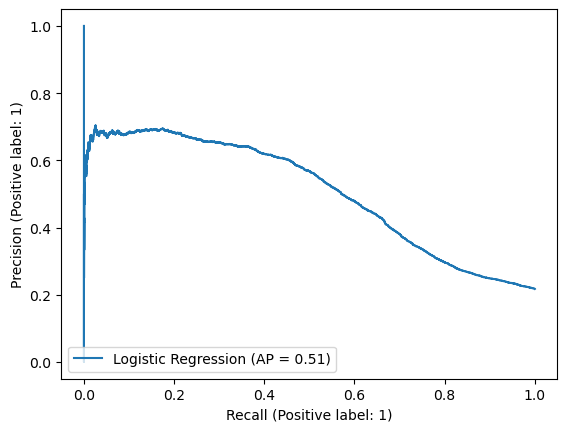

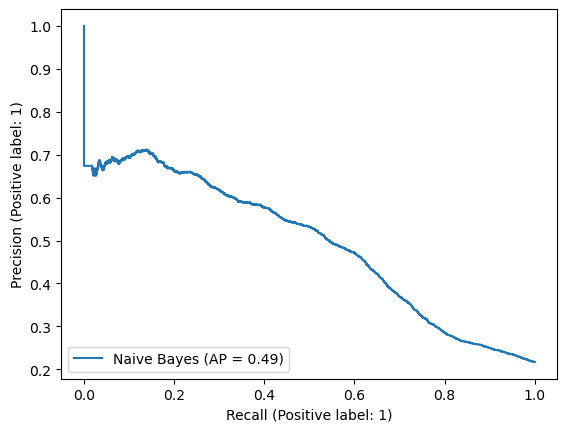

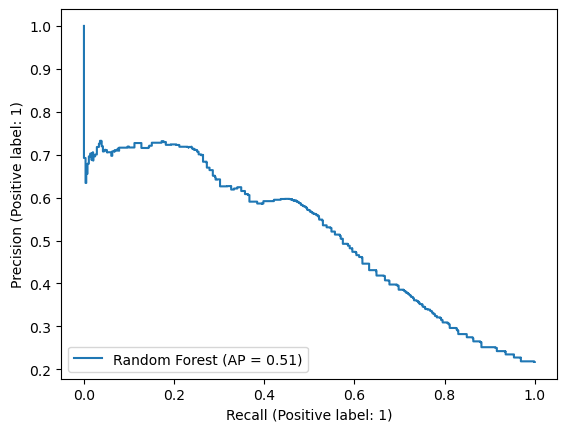

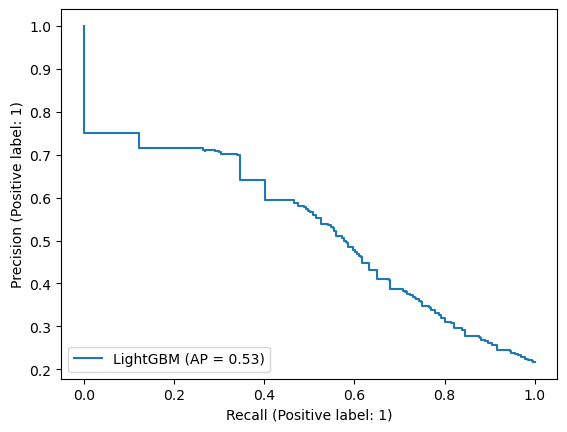

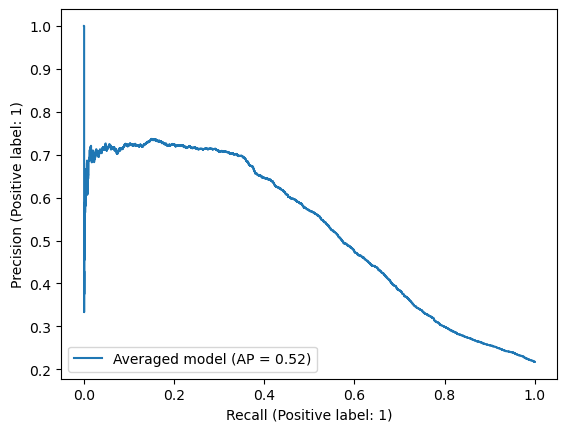

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(random_search_logreg, X_train, y_train,name = "Logistic Regression")
PrecisionRecallDisplay.from_estimator(random_search_NB, X_train, y_train,name = "Naive Bayes")
PrecisionRecallDisplay.from_estimator(random_search_RF, X_train, y_train,name = "Random Forest")
PrecisionRecallDisplay.from_estimator(random_search_LGBM, X_train, y_train,name = "LightGBM")
PrecisionRecallDisplay.from_estimator(averaged_model, X_train, y_train,name = "Averaged model")

In [60]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
col_list_opt
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM_bal,LGBM_bal_RFE,LGBM_opt,NB_bal,NB_bal_RFE,NB_opt,RF_bal,RF_bal_RFE,RF_opt,averaged,dummy,logreg,logreg_RFE
fit_time,0.354,5.584,4.350,0.035,3.605,0.058,4.587,7.656,6.919,317.900,0.004,0.115,3.628
score_time,0.044,0.045,0.033,0.015,0.022,0.026,0.097,0.132,0.072,0.107,0.007,0.016,0.016
test_accuracy,0.768,0.765,0.754,0.434,0.809,0.434,0.820,0.769,0.763,0.658,0.783,0.737,0.739
train_accuracy,0.830,0.792,0.753,0.434,0.809,0.434,1.000,0.987,0.763,0.658,0.783,0.739,0.739
test_precision,0.474,0.469,0.453,0.260,0.569,0.260,0.670,0.499,0.466,0.373,0.000,0.431,0.432
train_precision,0.582,0.516,0.452,0.260,0.570,0.260,1.000,0.965,0.465,0.373,0.000,0.433,0.433
test_recall,0.610,0.603,0.628,0.865,0.500,0.865,0.338,0.381,0.613,0.713,0.000,0.654,0.642
train_recall,0.778,0.675,0.630,0.866,0.501,0.866,1.000,0.978,0.615,0.716,0.000,0.653,0.643
test_f1,0.533,0.527,0.526,0.399,0.532,0.399,0.449,0.422,0.529,0.482,0.000,0.519,0.517
train_f1,0.666,0.584,0.526,0.399,0.533,0.399,1.000,0.971,0.530,0.483,0.000,0.521,0.517


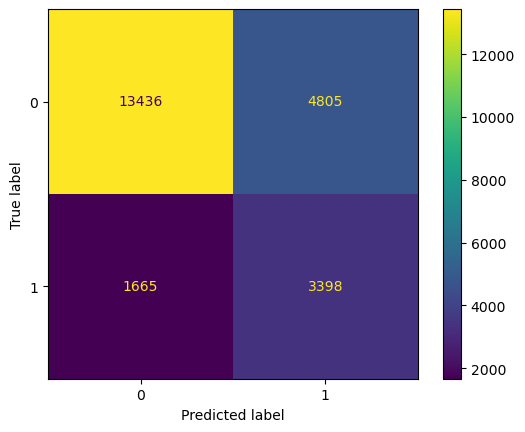

In [61]:
ConfusionMatrixDisplay.from_estimator(averaged_model, X_train, y_train )

In [62]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_train, averaged_model.predict(X_train)
    )
)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81     18241
           1       0.41      0.67      0.51      5063

    accuracy                           0.72     23304
   macro avg       0.65      0.70      0.66     23304
weighted avg       0.79      0.72      0.74     23304



<div class="alert alert-info">

## 11. Interpretation and feature importances <a name="1"></a>

As an exercise, the most important features of a non-linear model, say LGBM, are examined. Based on `eli5`, `permutation importance`, and `SHAP` we can see that `PAY_0` and `longest_unpaid_streak` are extremely significant in the LGBM model. This makes reasonable sense, as an individual starting the payment period already having an unpaid balance (`PAY_0`) is likely to continue to not pay and eventually default, and individuals with longer extended streaks of not paying (`longest_unpaid_streak`) are more likely to eventually default.

Interestingly, total bill amount, total pay amount and average payment ratio are not selected as significant features in our model.

In [63]:
indices = random_search_LGBM.best_estimator_.named_steps["rfecv"].get_support(indices=True).tolist()
features = numeric_features + ordinal_features + preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
feature_names = [features[i] for i in indices]

# extracting names of relevant features passed through transformer and RFE

In [64]:
import eli5
eli5.explain_weights(random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"], feature_names=feature_names)

Weight,Feature
0.5919,longest_unpaid_streak
0.2926,PAY_0
0.0594,PAY_2
0.0511,BILL_AMT1
0.0050,MARRIAGE_1


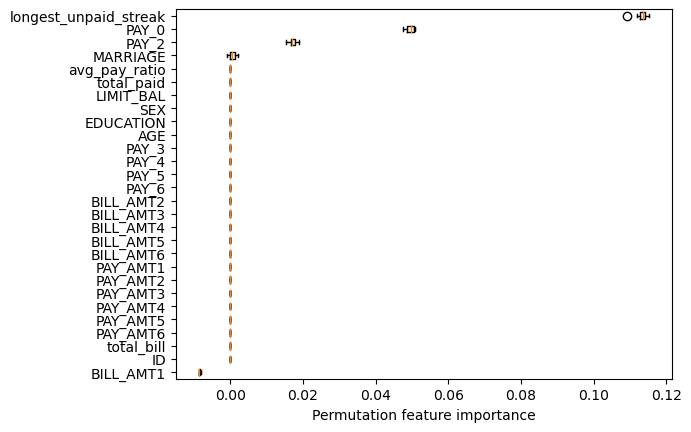

In [65]:
from sklearn.inspection import permutation_importance

# adapted from "get_permutation_importance" function from 573 Lec 8
perm_imp = permutation_importance(random_search_LGBM.best_estimator_, X_train, y_train, n_repeats=10, random_state=123)
perm_imp_sorted = perm_imp.importances_mean.argsort()
plt.boxplot(
    perm_imp.importances[perm_imp_sorted].T,
    vert=False,
    labels=X_train.columns[perm_imp_sorted])
plt.xlabel('Permutation feature importance')
plt.show()

In [66]:
X_train_transformed = pd.DataFrame(data = preprocessor.transform(X_train)[:,indices], 
                                   columns = feature_names, 
                                   index=X_train.index)
# Select only `indices` columns of the dataframe and this should work

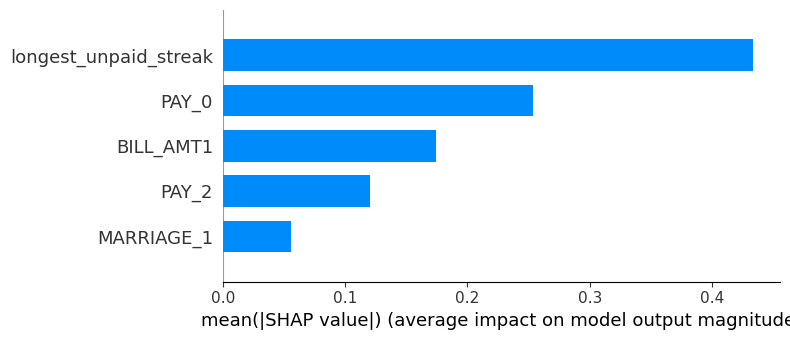

In [67]:
import shap
lgbm_shap = shap.TreeExplainer(random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"])
training_shap = lgbm_shap.shap_values(X_train_transformed)

shap.summary_plot(training_shap[1], X_train_transformed, plot_type = 'bar')

<div class="alert alert-info">

## 12. Results on the test set <a name="12"></a>

We now test our chosen model on the test data and examine the results. The recall score on our test dataset is 65.8% which is slightly lower than our train and validation scores. This is reasonable and makes sense. So our model is performing well. We do not have optimization bias because our dataset is large enough and we used pipeline to perform cross-validation. Also, we do not observe acute overfitting from the scores.

We will take one default=0 and one default=1 predictions and perform SHAP force plots.

default=0:
- This individual has a negative longest_unpaid_streak which is a sign of a good repayment record. (factor pushing to default=0)
- He/she has very low PAY_0 and PAY_2. That means there is no repayment issue with in recent months. (factor pushing to default=0)
- He/she is married. This is a slightly negative factor according to our model but this (factor pushing to default=1), but this is small in comparison to payment habits above.
- Summing up all the factors, the prediction for this individual is no default which matches the actual label.

default=1:
- This individual has a relatively large longest_unpaid_streak which is a negative sign. (factor pushing to default=1)
- He/she has a quite high PAY_0. (factor pushing to default=1)
- These two factors are already strong enough to predict this individual will default, which matches the actual label.

In [68]:
from sklearn.metrics import recall_score

recall_score(y_test, averaged_model.predict(X_test))

0.6584394904458599

In [69]:
lgbm_explainer = shap.TreeExplainer(random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"])
X_test_transformed = pd.DataFrame(data = preprocessor.transform(X_test)[:,indices], 
                                   columns = feature_names, 
                                   index=X_test.index)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_transformed)

In [70]:
y_test_reset = y_test.reset_index(drop=True)

defaultN_ind = y_test_reset[y_test_reset == 0].index.tolist()
defaultY_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_defaultN_index = defaultN_ind[9]
ex_defaultY_index = defaultY_ind[10]

In [71]:
X_test_transformed.iloc[ex_defaultN_index]

PAY_0                    0.010009
PAY_2                    0.066240
BILL_AMT1                3.968337
longest_unpaid_streak   -0.345348
MARRIAGE_1               1.000000
Name: 11992, dtype: float64

In [72]:
# hard prediction
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict(X_test_transformed)[ex_defaultN_index]

0

In [73]:
# predict_proba
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_defaultN_index]

array([0.68591368, 0.31408632])

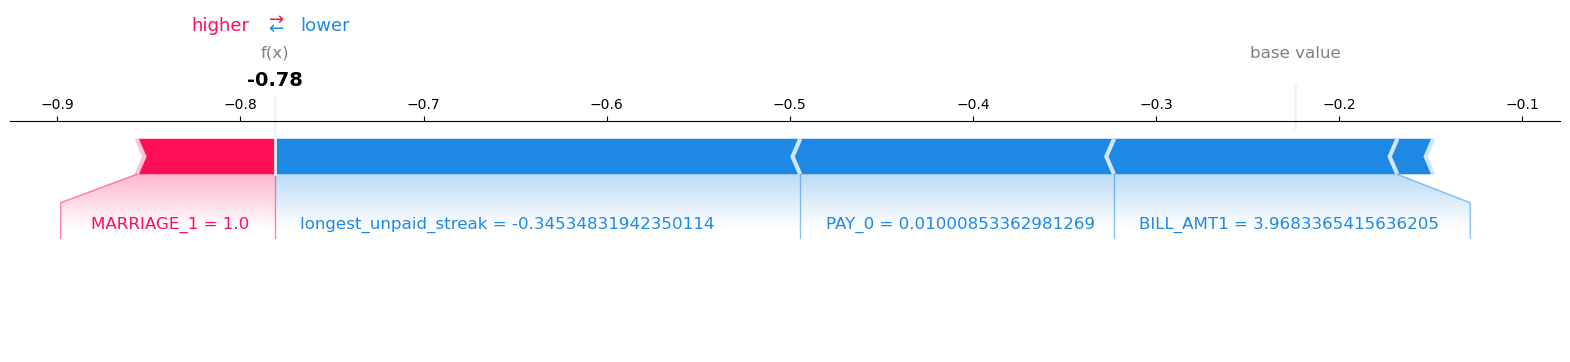

In [74]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_defaultN_index, :], # SHAP values associated with the example we want to explain
    X_test_transformed.iloc[ex_defaultN_index, :], # Feature vector of the example 
    matplotlib=True,
)

In [75]:
X_test_transformed.iloc[ex_defaultY_index]

PAY_0                    1.811081
PAY_2                    0.066240
BILL_AMT1               -0.397301
longest_unpaid_streak    1.149589
MARRIAGE_1               0.000000
Name: 15154, dtype: float64

In [76]:
# hard prediction
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict(X_test_transformed)[ex_defaultY_index]

1

In [77]:
# predict_proba
random_search_LGBM.best_estimator_.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_defaultY_index]

array([0.18117055, 0.81882945])

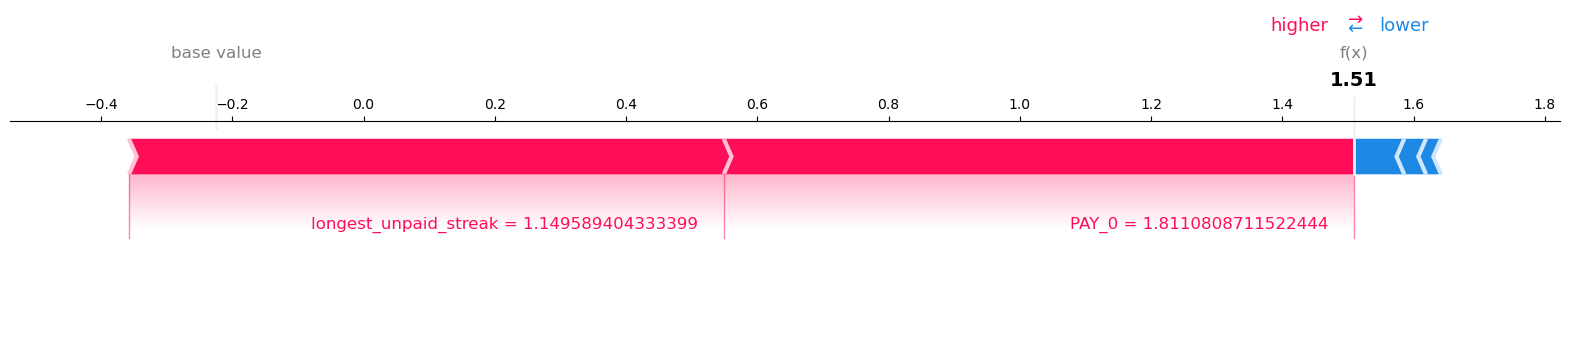

In [78]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_defaultY_index, :], # SHAP values associated with the example we want to explain
    X_test_transformed.iloc[ex_defaultY_index, :], # Feature vector of the example 
    matplotlib=True,
)

<div class="alert alert-info">

## 13. Summary of results <a name="13"></a>

The goal of this project is to correctly predict if a credit card customer is going to default in the coming month. Since catching defaults is the first priority, recall is used as the scoring metric throughout our analysis. Recall is defined as the percentage of actual defaults that are be predicted correctly by our model.

We made use of the Default of Credit Card Clients Dataset in which there is information such as
- Limit balance
- Education level
- Marriage status
- Repayment status
- Amount billed
- Amount paid
- Our target 'whether default payment happened next month'.

We performed feature engineering to create new features based on the base features. The newly created features are:
- Longest unpaid streak
- Total bill amount
- Total paid amount
- Average payment ratio<br>

**Longest unpaid streak ended up being the most important factor for prediction, meaning our feature engineering was very successful.**

The data is split into two parts randomly: train set and test set. The train set was used to train our prediction model while the test set was left untouched until the end of model tuning to evaluate our model.

In order to achieve the goal, we have used different classification models:
- Logistic Regression
- (Gaussian) Naive Bayes
- Random Forest
- LightGBM

Since each model has its own pros and cons, we used feature selection and hyperparameter optimization to generate the optimal version of each model. In order to benefit from diversification, we applied a vote classifier that took the average of 4 best models. The cross validation recall score from our train set was 71.3%, with significantly higher precision than our original NB model. We opted to select the voting model because, despite a lower recall metric, the model did have far more robust `AP` and `f1` scores. While these are not our primary metric, they are still significant. Cross validation scores are shown in the table below.

We applied our diversified averaged model to the test set for a final evaluation. The score is 65.8% which is slightly less than the score from the train set.

The breakdown of true positives, true negatives, false positives and false negatives in the test set are shown in the Confusion Matrix below (Note: label 1 means default).

Although our recall score is pretty good, it is worth noting that there are a number of false positives as well (i.e. low precision). From the Precision-Recall curve, we can see the trade-off between precision and recall. We can strike the balance by choosing an appropriate operating point later after thorough discussion.

Among the features available in the data file, our training process identified 5 features which are the most important to our prediction. They are shown in the SHAP plot. Among them `longest_unpaid_streak` and `PAY_0` are the most important features meaning they have the biggest influence in the model. Both of them are important indicators about a bad client based on the recent repayment record.

Some ideas that may further improve our models:
- More feature engineering such as "number of months with repayment issues"
- More classification models such as SVC
- Other feature selection techniques such as forward / backward selection
- More extensive hyperparameter optimization with wider parameter distribution / grid
- Choosing an appropriate operating point

In [79]:
final = ['logreg_RFE', 'LGBM_opt', 'NB_opt', 'RF_opt', 'averaged']
df = pd.DataFrame(combined_results_opt.loc['test_recall', final])
df.columns = ['Recall Score (CV on train set)']
df.index = ['Logistic Regression', 'LightGBM', 'Naive Bayes', 'Random Forest', 'AVERAGED MODEL']
df

,Recall Score (CV on train set)
Logistic Regression,0.642
LightGBM,0.628
Naive Bayes,0.865
Random Forest,0.613
AVERAGED MODEL,0.713


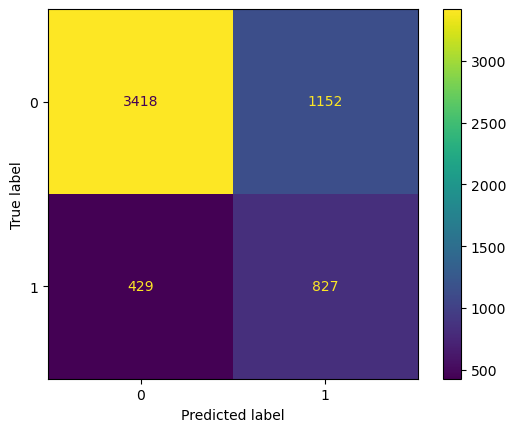

In [80]:
ConfusionMatrixDisplay.from_estimator(averaged_model, X_test, y_test )

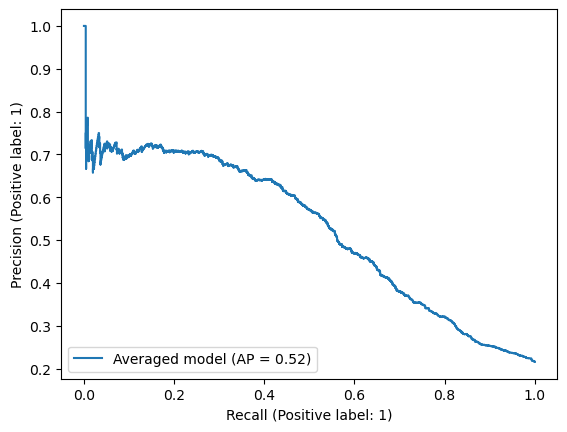

In [81]:
PrecisionRecallDisplay.from_estimator(averaged_model, X_test, y_test,name = "Averaged model")

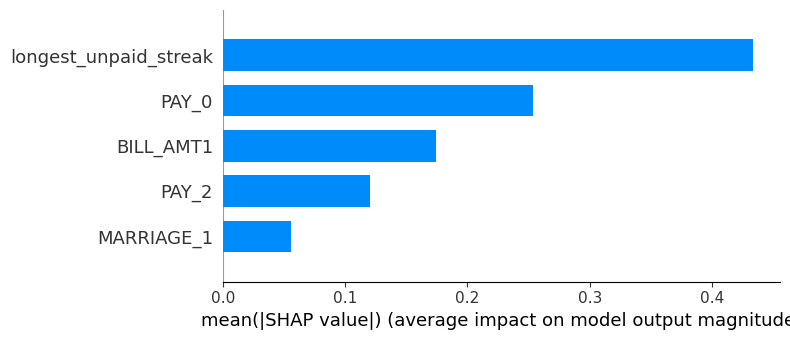

In [82]:
shap.summary_plot(training_shap[1], X_train_transformed, plot_type = 'bar')